In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import sys
from scipy.stats import halfnorm

In [15]:
# data = torch.load('../../pre_calculated_logits/cifar10_resnet50.pt') #(0.2011429145933566, 0.19180566818188102)
# data = torch.load('../../pre_calculated_logits/cifar10_resnet110.pt') # (0.21394572407063817, 0.2036991789954139)
# data = torch.load('../../pre_calculated_logits/cifar10_densenet121.pt') # (0.21367631107570084, 0.21775027366545502)
data = torch.load('../../pre_calculated_logits/cifar10_wide_resnet.pt') # (0.27101995051350897, 0.24667724243540734)

# data = torch.load('../../pre_calculated_logits/cifar100_resnet50.pt') # (0.3034935742626169, 0.27132700383761355)
# data = torch.load('../../pre_calculated_logits/cifar100_densenet121.pt') # (0.40484805405162416, 0.4310961812758797)
# data = torch.load('../../pre_calculated_logits/cifar100_wide_resnet.pt') # (0.5086688101293193, 0.4584319144998693)
# data = torch.load('../../pre_calculated_logits/cifar100_resnet110.pt') #(0.35051931440879475, 0.34520472586423406)

# data = torch.load('../../pre_calculated_logits/imagenet_resnet50.pt') # (0.6759873926694504, 0.6778855025849704)
data_fc = torch.load('../../pre_calculated_logits/cifar10_resnet50_fc.pt') 
# data = torch.load('../../pre_calculated_logits/imagenet_vit_b_16.pt')
# data = torch.load('../../pre_calculated_logits/imagenet_efficientnet_b0.pt')
load_features = data['features_val']
labels = data['labels_val']
logits = data['logits_val']
load_features.shape, labels.shape, logits.shape
load_features_fc = data_fc['features_val_fc']
labels_fc = data_fc['labels_val_fc']
logits_fc = data_fc['logits_val_fc']
load_features_fc.shape, labels_fc.shape, logits_fc.shape

# get wrongly prediction index with the confidence larger than 0.95
wrong_index = torch.where((labels != logits.argmax(dim=1)) & (F.softmax(logits, dim=1).max(dim=1).values > 0.8))[0]
# get correct prediction index with the confidence larger than 0.95
correct_index = torch.where((labels == logits.argmax(dim=1)) & (F.softmax(logits, dim=1).max(dim=1).values > 0.8))[0]
len(wrong_index), len(correct_index)


wrong_feature = load_features[wrong_index].flatten().cpu().numpy()
correct_feature = load_features[correct_index].flatten().cpu().numpy()
feature = load_features.flatten().cpu().numpy()
# remove all zeros
# wrong_feature = wrong_feature[wrong_feature != 0]
# correct_feature = correct_feature[correct_feature != 0]

# halfnorm.fit(correct_feature)[1], halfnorm.fit(wrong_feature)[1]
len(feature[feature == 0])/len(feature)


0.1134125

In [ ]:
from scipy.stats import halfcauchy
from scipy.stats import halfnorm

x_range = (0.0, 1)
features = load_features

# plot the histogram of feature value of all units, except values largers than 0.4
# feature_index=np.random.choice(features.shape[1], 100)
feature_index=range(features.shape[1])


plt.figure(figsize=(8,4))

#plot the pdf as pdf
wrong_hist = plt.hist(features[wrong_index][feature_index].flatten().cpu().numpy(), bins=100, range=x_range, alpha=0.5, label='Wrong', density=True)
correct_hist= plt.hist(features[correct_index][:len(wrong_index)][feature_index].flatten().cpu().numpy(), bins=100, range=x_range, alpha=0.5, label='Correct', density=True)

# plt.figure(figsize=(8,4))

# #plot the pdf as pdf
# wrong_hist = plt.hist(features[wrong_index].flatten().cpu().numpy(), bins=100, range=(0.0, 0.1), alpha=0.5, label='Wrong', density=True)
# correct_hist= plt.hist(features[correct_index][:len(wrong_index)].flatten().cpu().numpy(), bins=100, range=(0.0, 0.1), alpha=0.5, label='Correct', density=True)


# adding a fitted halfcauchy distribution curve
x = np.linspace(x_range[0],x_range[1], 100)
mean, std = halfcauchy.fit(features[wrong_index][feature_index].flatten().cpu().numpy())
pdf = halfcauchy.pdf(x, loc=mean, scale=std)
plt.plot(x, pdf, 'r-')
print(std)

mean, std = halfcauchy.fit(features[correct_index][feature_index].flatten().cpu().numpy())
pdf = halfcauchy.pdf(x, loc=mean, scale=std)
plt.plot(x, pdf, 'b-')
print(std)
# # adding a curve to fit the histogram, make it smooth
# plt.plot(wrong_hist[1][1:], wrong_hist[0], 'r-')
# plt.plot(correct_hist[1][1:], correct_hist[0], 'b-')


plt.xlabel('Feature Value')
plt.ylabel('Frequency')
plt.legend()
plt.tight_layout()
plt.show()

In [3]:
# calculate the mean entropy of wrong prediction before fc
entropy = -F.softmax(logits[wrong_index], dim=1) * F.log_softmax(logits[wrong_index], dim=1)
entropy = entropy.sum(dim=1)
print("wrong before fc: ",entropy.mean())

# calculate the mean entropy of correct prediction before fc
entropy = -F.softmax(logits[correct_index], dim=1) * F.log_softmax(logits[correct_index], dim=1)
entropy = entropy.sum(dim=1)
print("correct before fc: ",entropy.mean())

# calculate the mean entropy of wrong prediction after fc
entropy = -F.softmax(logits_fc[wrong_index], dim=1) * F.log_softmax(logits_fc[wrong_index], dim=1)
entropy = entropy.sum(dim=1)
print("wrong after fc: ",entropy.mean())

# calculate the mean entropy of correct prediction after fc
entropy = -F.softmax(logits_fc[correct_index], dim=1) * F.log_softmax(logits_fc[correct_index], dim=1)
entropy = entropy.sum(dim=1)
print("correct after fc: ",entropy.mean())

wrong before fc:  tensor(0.0824, device='cuda:0')
correct before fc:  tensor(0.0032, device='cuda:0')
wrong after fc:  tensor(0.5723, device='cuda:0')
correct after fc:  tensor(0.1525, device='cuda:0')


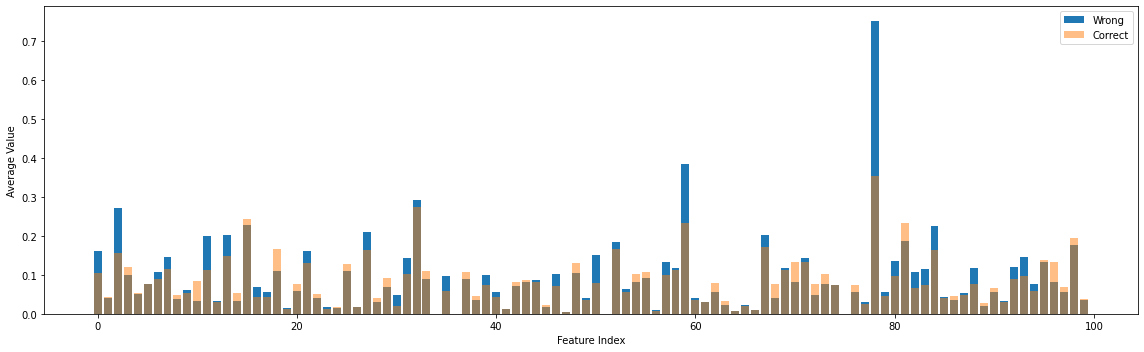

In [4]:
# randomly select 100 units from the feature
selected_units = np.random.choice(load_features.shape[1], 100, replace=True)
features = load_features[:,selected_units]
# plot all features of worngly predicted samples using bar char, x-axis is each unit of features, y-axis is the average value of each unit
plt.figure(figsize=(16, 5))
plt.bar(np.arange(features.shape[1]), features[wrong_index].mean(dim=0).cpu())
# plot all features of correctly predicted samples using bar char, x-axis is each unit of features, y-axis is the average value of each unit in one figure
plt.bar(np.arange(features.shape[1]), features[correct_index].mean(dim=0).cpu(), alpha=0.5)
plt.xlabel('Feature Index')
plt.ylabel('Average Value')
# plt.title('Feature Distribution')
plt.legend(['Wrong', 'Correct'])
plt.tight_layout()
plt.savefig('feature_distribution.pdf')
plt.show()


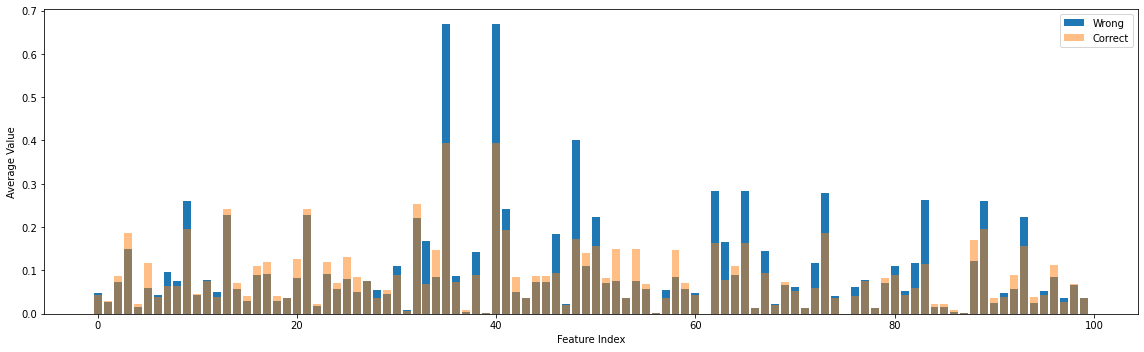

In [5]:
# randomly select 100 units from the feature
selected_units = np.random.choice(features.shape[1], 100, replace=True)
features = load_features[:,selected_units]
# plot all features of worngly predicted samples using bar char, x-axis is each unit of features, y-axis is the average value of each unit
plt.figure(figsize=(16, 5))
plt.bar(np.arange(features.shape[1]), torch.abs(features[wrong_index]).mean(dim=0).cpu())
# plot all features of correctly predicted samples using bar char, x-axis is each unit of features, y-axis is the average value of each unit in one figure
plt.bar(np.arange(features.shape[1]), torch.abs(features[correct_index]).mean(dim=0).cpu(), alpha=0.5)


plt.xlabel('Feature Index')
plt.ylabel('Average Value')
# plt.title('Feature Distribution')
plt.legend(['Wrong', 'Correct'])
plt.tight_layout()
plt.savefig('feature_distribution.pdf')
plt.show()
